## Install and Import

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
from sklearn.metrics import classification_report
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

## Load Dataset


In [ ]:
df2 = pd.read_csv("sem18(train+test)and sem22(train with data aug)+(13k).csv")

In [ ]:
df2

,Unnamed: 0,tweet,sarcastic
0,0,the biggest only problem thing i got from coll...,1
1,1,the absolutely only thing i got fired from the...,1
2,2,perhaps the second only nice thing i got out f...,1
3,3,i love it when college professors randomly dra...,1
4,4,i really love it funny when professors constan...,1
...,...,...,...
19981,19981,['8-9ft man found in ancient indian burial mou...,0
19982,19982,"[""Second Scottish independence referendum 'on ...",0
19983,19983,"['Pinoy Cyborg by James Simmons', 'Mag-ingat s...",0
19984,19984,"['The logic here is flawless!', ""No it isn't, ...",0


In [ ]:
df2 = df2[["tweet","sarcastic"]]

In [ ]:
df = df2

In [ ]:
df.sample(10)

,tweet,sarcastic
11788,"[""@USER @USER @USER so should we just accept t...",1
477,just getting us some wd40 tickets on board my ...,1
12491,"[""Meghan Markle reveals details of secret meet...",1
8196,<user> to you too . <happy> 👍,0
17587,"[""Some Kansas schools will not have enough fun...",1
7969,<user> <user> i smashed my samsung galaxy runn...,1
7394,<hashtag> terror </hashtag> on high seas . <re...,0
14694,['Continuing to map out the general whereabout...,0
16747,['Comcast fined $33 million for publishing unl...,1
4012,@LittleBigPlanet Thanks for the update. No nee...,0


In [ ]:
df["sarcastic"].value_counts()

1    10478
0     9508
Name: sarcastic, dtype: int64

In [ ]:
df["tweet"].value_counts()  # value counts of tweet 

['SGT Bergdahl freed in exchange for 5 Taliban', "I'm annoyed that they promoted a deserter."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     1
<user> i am really big supporter of <hashtag> law enforcement </hashtag> . like sheriff clarke said , it ' s all theatrics . <hashtag> ferguson </hashtag> <user>                                                                                                                                                                                   

In [ ]:
df = df.drop_duplicates(subset=["tweet"])  # removal of duplicate tweet

In [ ]:
df["tweet"].value_counts()

['SGT Bergdahl freed in exchange for 5 Taliban', "I'm annoyed that they promoted a deserter."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     1
<user> i am really big supporter of <hashtag> law enforcement </hashtag> . like sheriff clarke said , it ' s all theatrics . <hashtag> ferguson </hashtag> <user>                                                                                                                                                                                   

In [ ]:
df

,tweet,sarcastic
0,the biggest only problem thing i got from coll...,1
1,the absolutely only thing i got fired from the...,1
2,perhaps the second only nice thing i got out f...,1
3,i love it when college professors randomly dra...,1
4,i really love it funny when professors constan...,1
...,...,...
19981,['8-9ft man found in ancient indian burial mou...,0
19982,"[""Second Scottish independence referendum 'on ...",0
19983,"['Pinoy Cyborg by James Simmons', 'Mag-ingat s...",0
19984,"['The logic here is flawless!', ""No it isn't, ...",0


In [ ]:
df.to_csv("sem18(train+test)and sem22(train with data aug)+(13k).csv")

## Data Cleaning

In [ ]:
import re
from nltk.corpus import stopwords  ## stopwords from nltk corpus
import nltk
b = list(df["tweet"])
nltk.download('wordnet')
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
import string
exclude = set(string.punctuation)
corpus = []
for i in range(len(b)):                         # use of regular expression to clean the data
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    
    TAG_RE = re.compile(r'<[^>]+>')
    review = TAG_RE.sub('', review)

    review = re.sub('\[[^]]*\]', ' ', review)
    
    review = review.lower()
    review = review.split()
    
    review = ' '.join(review)

    

    

    corpus.append(review)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = df.assign(clean_headlines = corpus)

In [ ]:
df

,tweet,sarcastic,clean_headlines
0,the biggest only problem thing i got from coll...,1,the biggest only problem thing i got from coll...
1,the absolutely only thing i got fired from the...,1,the absolutely only thing i got fired from the...
2,perhaps the second only nice thing i got out f...,1,perhaps the second only nice thing i got out f...
3,i love it when college professors randomly dra...,1,i love it when college professors randomly dra...
4,i really love it funny when professors constan...,1,i really love it funny when professors constan...
...,...,...,...
19981,['8-9ft man found in ancient indian burial mou...,0,['8-9ft man found in ancient indian burial mou...
19982,"[""Second Scottish independence referendum 'on ...",0,"[""second scottish independence referendum 'on ..."
19983,"['Pinoy Cyborg by James Simmons', 'Mag-ingat s...",0,"['pinoy cyborg by james simmons', 'mag-ingat s..."
19984,"['The logic here is flawless!', ""No it isn't, ...",0,"['the logic here is flawless!', ""no it isn't, ..."


In [ ]:
# Create sentence and label lists
sentences = df.clean_headlines.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.sarcastic.values

## Inputs

Next, import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

In [ ]:
!pip install pytorch-transformers
!pip install transformers

In [ ]:
from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

from tqdm import tqdm, trange

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'the', 'biggest', 'only', 'problem', 'thing', 'i', 'got', 'from', 'college', 'is', 'a', 'strong', 'caf', '##fe', '##ine', 'heroin', 'addiction', '[SEP]']


In [ ]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [ ]:
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (549 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (556 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (573 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (982 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (574 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length f

In [ ]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (549 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (556 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (573 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (982 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (574 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length f

In [ ]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create the attention masks 

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Train Model

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [ ]:
param_optimizer = list(model.named_parameters())  ## parameter optimizer
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (recommend between 2 and 4)
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  predictions , true_labels = [], []

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
    predictions.append(logits)
    true_labels.append(label_ids)
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()    
    flat_true_labels = [item for sublist in true_labels for item in sublist]
  
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
  print(classification_report(flat_true_labels, flat_predictions))
  

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.6350376592753836


Epoch:  33%|███▎      | 1/3 [04:42<09:24, 282.10s/it]

Validation Accuracy: 0.6971560846560847
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       963
           1       0.70      0.73      0.71      1036

    accuracy                           0.70      1999
   macro avg       0.70      0.70      0.70      1999
weighted avg       0.70      0.70      0.70      1999

Train loss: 0.47513949413176754


Epoch:  67%|██████▋   | 2/3 [09:23<04:41, 281.71s/it]

Validation Accuracy: 0.7201719576719576
              precision    recall  f1-score   support

           0       0.67      0.80      0.73       963
           1       0.78      0.64      0.70      1036

    accuracy                           0.72      1999
   macro avg       0.73      0.72      0.72      1999
weighted avg       0.73      0.72      0.72      1999

Train loss: 0.29126106904320037


Epoch: 100%|██████████| 3/3 [14:04<00:00, 281.66s/it]

Validation Accuracy: 0.7085648148148148
              precision    recall  f1-score   support

           0       0.76      0.58      0.66       963
           1       0.68      0.82      0.75      1036

    accuracy                           0.71      1999
   macro avg       0.72      0.70      0.70      1999
weighted avg       0.72      0.71      0.70      1999



## Training Evaluation

Let's take a look at our training loss over all batches:

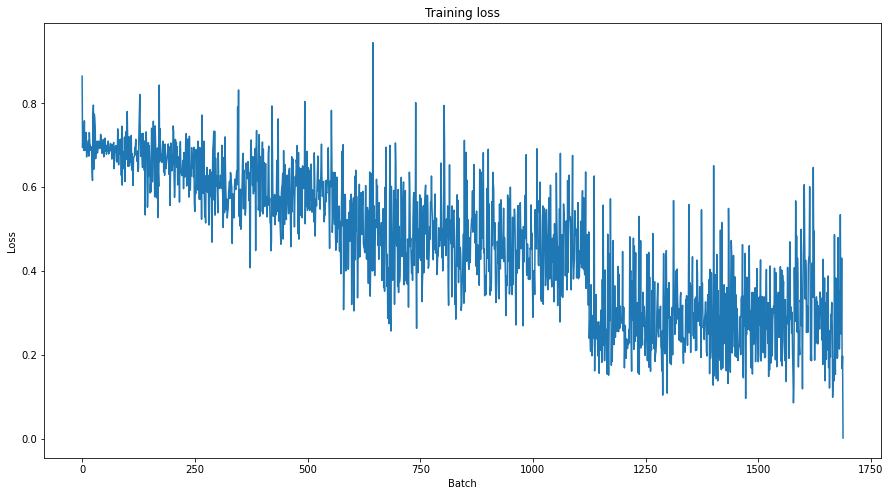

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Prediction on test data 

In [ ]:
df1 = pd.read_csv("train.En.csv")  # train data for sub-task A 

In [ ]:
df1

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3463,3463,The population spike in Chicago in 9 months is...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3464,3464,You'd think in the second to last English clas...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3465,3465,I’m finally surfacing after a holiday to Scotl...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3466,3466,Couldn't be prouder today. Well done to every ...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning for test data 

In [ ]:
import re                                                       ### Data Cleaning for test data 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
ps = PorterStemmer()


b = list(df1["tweet"])


wordnet=WordNetLemmatizer()
nltk.download('wordnet')
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
import string
exclude = set(string.punctuation)
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    
    
    review = re.sub('\[[^]]*\]', ' ', review)
    
    review = review.lower()
    review = review.split()
    
    review = ' '.join(review)

    

    corpus.append(review)
df1 = df1.assign(clean_tweet = corpus)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df1

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question,clean_tweet
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0,the only thing i got from college is a caffein...
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0,i love it when professors draw a big question ...
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0,remember the hundred emails from companies whe...
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0,today my pop-pop told me i was not “forced” to...
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0,"i did too, and i also reported cancun cruz not..."
...,...,...,...,...,...,...,...,...,...,...,...
3463,3463,The population spike in Chicago in 9 months is...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,the population spike in chicago in 9 months is...
3464,3464,You'd think in the second to last English clas...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,you'd think in the second to last english clas...
3465,3465,I’m finally surfacing after a holiday to Scotl...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,i’m finally surfacing after a holiday to scotl...
3466,3466,Couldn't be prouder today. Well done to every ...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,couldn't be prouder today. well done to every ...


In [ ]:
df1 = df1.drop(["rephrase","sarcasm","irony","satire","understatement","overstatement","rhetorical_question","Unnamed: 0","tweet"],axis=1)

In [ ]:
df1

,sarcastic,clean_tweet
0,1,the only thing i got from college is a caffein...
1,1,i love it when professors draw a big question ...
2,1,remember the hundred emails from companies whe...
3,1,today my pop-pop told me i was not “forced” to...
4,1,"i did too, and i also reported cancun cruz not..."
...,...,...
3463,0,the population spike in chicago in 9 months is...
3464,0,you'd think in the second to last english clas...
3465,0,i’m finally surfacing after a holiday to scotl...
3466,0,couldn't be prouder today. well done to every ...


In [ ]:


# Create sentence and label lists
sentences = df1.clean_tweet.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df1.sarcastic.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


In [ ]:
matthews_set

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [ ]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.92116793611515

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(flat_true_labels, flat_predictions))   # classification report 

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2601
           1       0.92      0.97      0.94       867

    accuracy                           0.97      3468
   macro avg       0.95      0.97      0.96      3468
weighted avg       0.97      0.97      0.97      3468



In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(flat_true_labels, flat_predictions, average='macro')  # macro F1-score

0.9603087013803664

In [ ]:
flat_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(flat_true_labels, flat_predictions)

array([[2526,   75],
       [  30,  837]])

In [ ]:
test_data = pd.read_csv("taskA.En.input.csv")    # test data for sub-task A  

In [ ]:
test_data

,text
0,"Size on the the Toulouse team, That pack is mo..."
1,Pinball!
2,So the Scottish Government want people to get ...
3,villainous pro tip : change the device name on...
4,I would date any of these men 🥺
...,...
1395,I’ve just seen this and felt it deserved a Ret...
1396,Omg how an earth is that a pen !!! 🤡
1397,Bringing Kanye and drake to a tl near you
1398,"I love it when women are referred to as ""girl ..."


In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
ps = PorterStemmer()


b = list(test_data["text"])


wordnet=WordNetLemmatizer()
nltk.download('wordnet')
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
import string
exclude = set(string.punctuation)
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    
    
    review = re.sub('\[[^]]*\]', ' ', review)
    
    review = review.lower()
    review = review.split()
    
    review = ' '.join(review)

    

    corpus.append(review)
test_data = test_data.assign(clean_text = corpus)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
test_data = test_data.assign(random_label=[0 for i in range(len(test_data["clean_text"]))])

In [ ]:
test_data

,text,clean_text,random_label
0,"Size on the the Toulouse team, That pack is mo...","size on the the toulouse team, that pack is mo...",0
1,Pinball!,pinball!,0
2,So the Scottish Government want people to get ...,so the scottish government want people to get ...,0
3,villainous pro tip : change the device name on...,villainous pro tip : change the device name on...,0
4,I would date any of these men 🥺,i would date any of these men 🥺,0
...,...,...,...
1395,I’ve just seen this and felt it deserved a Ret...,i’ve just seen this and felt it deserved a ret...,0
1396,Omg how an earth is that a pen !!! 🤡,omg how an earth is that a pen !!! 🤡,0
1397,Bringing Kanye and drake to a tl near you,bringing kanye and drake to a tl near you,0
1398,"I love it when women are referred to as ""girl ...","i love it when women are referred to as ""girl ...",0


In [ ]:


# Create sentence and label lists
sentences = test_data.clean_text.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = test_data.random_label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [ ]:
flat_predictions

array([1, 0, 1, ..., 1, 1, 0])

In [ ]:
test_data = test_data.assign(predicted_label=list(flat_predictions))

In [ ]:
test_data

,text,clean_text,random_label,predicted_label
0,"Size on the the Toulouse team, That pack is mo...","size on the the toulouse team, that pack is mo...",0,1
1,Pinball!,pinball!,0,0
2,So the Scottish Government want people to get ...,so the scottish government want people to get ...,0,1
3,villainous pro tip : change the device name on...,villainous pro tip : change the device name on...,0,0
4,I would date any of these men 🥺,i would date any of these men 🥺,0,0
...,...,...,...,...
1395,I’ve just seen this and felt it deserved a Ret...,i’ve just seen this and felt it deserved a ret...,0,0
1396,Omg how an earth is that a pen !!! 🤡,omg how an earth is that a pen !!! 🤡,0,0
1397,Bringing Kanye and drake to a tl near you,bringing kanye and drake to a tl near you,0,1
1398,"I love it when women are referred to as ""girl ...","i love it when women are referred to as ""girl ...",0,1


In [ ]:
test_data = test_data.drop(["text","clean_text","random_label"],axis=1)

In [ ]:
test_data["predicted_label"].value_counts()

0    911
1    489
Name: predicted_label, dtype: int64

In [ ]:
test_data.to_csv("task_a_final.csv")

## Prediction on test data 

In [ ]:
sem18 = pd.read_csv("taskC.En.input.csv")

In [ ]:
sem18   # test data which contain two column text_o & text_1 

,text_0,text_1
0,I see that your team played well today!,I'm sorry that your team didn't win yesterday.
1,"Anthony Taylor is such a fair referee, I wish ...",I hope Anthony Taylor is never put in charge o...
2,"the weather is gloomy, just raining and dull.",What a glorious weather today
3,People going out to get there boosters without...,Nice to see the sheep getting their boosters t...
4,"Really great weather we're having, love a bit ...",Really cold January so far - looking forward t...
...,...,...
195,"the tories betrayed the nation, what a surprise!","the tories betrayed the nation, as expected"
196,Cant believe we have to spend the rest of our ...,Cant wait to spend the rest of my life waiting...
197,Isn't it just amazing how competent the govern...,"Everything is a total mess, how can anyone be ..."
198,Thanks Boris Johnson for restricting travel ab...,The reasoning behind the tightening of travel ...


##### Data cleaning for test data of Sub-Task C

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
ps = PorterStemmer()


b = list(sem18["text_0"])


wordnet=WordNetLemmatizer()
nltk.download('wordnet')
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
import string
exclude = set(string.punctuation)
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    
    TAG_RE = re.compile(r'<[^>]+>')
    review = TAG_RE.sub('', review)
    
    review = re.sub('\[[^]]*\]', ' ', review)
    
    review = review.lower()
    review = review.split()
    
    review = ' '.join(review)

    

    corpus.append(review)
sem18 = sem18.assign(clean_text0 = corpus)


import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
ps = PorterStemmer()


b = list(sem18["text_1"])


wordnet=WordNetLemmatizer()
nltk.download('wordnet')
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
import string
exclude = set(string.punctuation)
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    
    TAG_RE = re.compile(r'<[^>]+>')
    review = TAG_RE.sub('', review)
    
    review = re.sub('\[[^]]*\]', ' ', review)
    
    review = review.lower()
    review = review.split()
    
    review = ' '.join(review)

    

    corpus.append(review)
sem18 = sem18.assign(clean_text1 = corpus)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
sem18

,text_0,text_1,clean_text0,clean_text1
0,I see that your team played well today!,I'm sorry that your team didn't win yesterday.,i see that your team played well today!,i'm sorry that your team didn't win yesterday.
1,"Anthony Taylor is such a fair referee, I wish ...",I hope Anthony Taylor is never put in charge o...,"anthony taylor is such a fair referee, i wish ...",i hope anthony taylor is never put in charge o...
2,"the weather is gloomy, just raining and dull.",What a glorious weather today,"the weather is gloomy, just raining and dull.",what a glorious weather today
3,People going out to get there boosters without...,Nice to see the sheep getting their boosters t...,people going out to get there boosters without...,nice to see the sheep getting their boosters t...
4,"Really great weather we're having, love a bit ...",Really cold January so far - looking forward t...,"really great weather we're having, love a bit ...",really cold january so far - looking forward t...
...,...,...,...,...
195,"the tories betrayed the nation, what a surprise!","the tories betrayed the nation, as expected","the tories betrayed the nation, what a surprise!","the tories betrayed the nation, as expected"
196,Cant believe we have to spend the rest of our ...,Cant wait to spend the rest of my life waiting...,cant believe we have to spend the rest of our ...,cant wait to spend the rest of my life waiting...
197,Isn't it just amazing how competent the govern...,"Everything is a total mess, how can anyone be ...",isn't it just amazing how competent the govern...,"everything is a total mess, how can anyone be ..."
198,Thanks Boris Johnson for restricting travel ab...,The reasoning behind the tightening of travel ...,thanks boris johnson for restricting travel ab...,the reasoning behind the tightening of travel ...


In [ ]:
taskc = sem18

In [ ]:
taskc = taskc.assign(random_label=[1 for i in range(len(taskc["clean_text0"]))])

In [ ]:
taskc

,text_0,text_1,clean_text0,clean_text1,random_label
0,I see that your team played well today!,I'm sorry that your team didn't win yesterday.,i see that your team played well today!,i'm sorry that your team didn't win yesterday.,1
1,"Anthony Taylor is such a fair referee, I wish ...",I hope Anthony Taylor is never put in charge o...,"anthony taylor is such a fair referee, i wish ...",i hope anthony taylor is never put in charge o...,1
2,"the weather is gloomy, just raining and dull.",What a glorious weather today,"the weather is gloomy, just raining and dull.",what a glorious weather today,1
3,People going out to get there boosters without...,Nice to see the sheep getting their boosters t...,people going out to get there boosters without...,nice to see the sheep getting their boosters t...,1
4,"Really great weather we're having, love a bit ...",Really cold January so far - looking forward t...,"really great weather we're having, love a bit ...",really cold january so far - looking forward t...,1
...,...,...,...,...,...
195,"the tories betrayed the nation, what a surprise!","the tories betrayed the nation, as expected","the tories betrayed the nation, what a surprise!","the tories betrayed the nation, as expected",1
196,Cant believe we have to spend the rest of our ...,Cant wait to spend the rest of my life waiting...,cant believe we have to spend the rest of our ...,cant wait to spend the rest of my life waiting...,1
197,Isn't it just amazing how competent the govern...,"Everything is a total mess, how can anyone be ...",isn't it just amazing how competent the govern...,"everything is a total mess, how can anyone be ...",1
198,Thanks Boris Johnson for restricting travel ab...,The reasoning behind the tightening of travel ...,thanks boris johnson for restricting travel ab...,the reasoning behind the tightening of travel ...,1


In [ ]:


# Create sentence and label lists
sentences = taskc.clean_text0.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = taskc.random_label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions0 = [np.max(item) for sublist in predictions for item in sublist]
#flat_predictions0 = np.argmax(flat_predictions0, axis=1).flatten()
#flat_true_labels = [item for sublist in true_labels for item in sublist]

#print(classification_report(flat_true_labels, flat_predictions))


In [ ]:
flat_predictions0

[1.7608713,
 0.7080813,
 1.706366,
 0.15219535,
 1.5920824,
 1.1219702,
 0.6854785,
 1.7624915,
 1.9944491,
 1.4736637,
 2.323301,
 2.2847092,
 0.43609494,
 1.6007919,
 1.9566172,
 0.63546205,
 0.74461955,
 1.658704,
 0.96399975,
 0.82162267,
 3.1465971,
 0.46826658,
 1.1068212,
 1.5555677,
 1.31186,
 3.0520391,
 1.8120421,
 1.8269125,
 1.1635934,
 3.3196397,
 2.434213,
 1.3402886,
 1.3657967,
 2.5562239,
 1.1562792,
 1.7933794,
 1.8260792,
 0.17328171,
 0.39557788,
 0.6207615,
 2.202608,
 0.33053026,
 2.5247989,
 3.0279028,
 0.27091256,
 2.1829696,
 0.34092072,
 1.583185,
 1.233443,
 1.0987856,
 2.5932965,
 0.4980228,
 -0.024251407,
 1.4970628,
 0.763232,
 1.2059063,
 1.6458799,
 2.1793153,
 1.7064028,
 3.3610067,
 0.162246,
 1.7355548,
 1.6160496,
 0.18319374,
 1.363882,
 2.009463,
 1.5163296,
 0.8032914,
 1.8956419,
 3.1878734,
 2.4562051,
 0.99606067,
 1.4184942,
 1.0046315,
 2.1023464,
 1.5441043,
 0.4998901,
 3.9285288,
 1.1495519,
 1.2540494,
 0.026416037,
 0.06649044,
 2.813441

In [ ]:


# Create sentence and label lists
sentences = taskc.clean_text1.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = taskc.random_label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions1 = [np.max(item) for sublist in predictions for item in sublist]
#flat_predictions0 = np.argmax(flat_predictions0, axis=1).flatten()
#flat_true_labels = [item for sublist in true_labels for item in sublist]

#print(classification_report(flat_true_labels, flat_predictions))


In [ ]:
flat_predictions1

[1.4679077,
 1.4400802,
 2.6561399,
 3.367429,
 1.3386084,
 1.5227206,
 1.0479062,
 1.1448731,
 0.69405824,
 1.7005635,
 2.5672622,
 3.4995508,
 2.3198347,
 2.3247402,
 1.9379154,
 1.3287985,
 0.8931776,
 0.5484964,
 1.6489308,
 1.5164059,
 3.128333,
 1.5314883,
 1.404349,
 1.7164679,
 1.5334486,
 1.7915276,
 0.6608538,
 0.54348123,
 1.8510358,
 1.1739231,
 0.43176135,
 3.0608797,
 2.1665251,
 1.6038399,
 0.40297428,
 1.9705648,
 2.571014,
 1.128703,
 0.73039913,
 1.7825264,
 2.99332,
 0.52142197,
 0.20927204,
 0.5062396,
 1.8319026,
 2.38039,
 1.1229845,
 3.4388268,
 0.15976065,
 1.0813674,
 1.2143278,
 3.3059874,
 3.4912477,
 1.8972281,
 1.2683961,
 2.7143078,
 1.1711962,
 1.1655042,
 0.8808457,
 2.0150483,
 0.1544349,
 1.9614111,
 0.20587264,
 0.35184857,
 0.9585289,
 1.8625627,
 0.152833,
 2.3907464,
 1.4349378,
 1.1432397,
 0.61627936,
 1.1487327,
 1.7137473,
 2.1910179,
 1.0764598,
 1.7068506,
 0.24799852,
 1.7704645,
 0.63463515,
 0.47715095,
 0.38354936,
 3.802936,
 0.50915056,

In [ ]:
task_c_en = []
for i in range(200):
  if flat_predictions0[i]>flat_predictions1[i]:
    task_c_en.append(0)
  if flat_predictions0[i]<flat_predictions1[i]:
    task_c_en.append(1)
task_c_en

[0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0]

In [ ]:
df_last = pd.DataFrame(task_c_en,columns=["task_c_en"])

In [ ]:
df_last

,task_c_en
0,0
1,1
2,1
3,1
4,0
...,...
195,0
196,1
197,0
198,0


In [ ]:
df_last["task_c_en"].value_counts()   # value counts of predicted labels

1    106
0     94
Name: task_c_en, dtype: int64

In [ ]:
df_last.to_csv("task_c_en.csv")

## Conclusion